In [36]:
%load_ext autoreload
%autoreload 2
#import nibabel as nib
import pandas as pd
import numpy as np
import seaborn as sns
from glob import glob
import os

import sys
sys.path.append('../src')
from helper import *
from time import time



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
!ls ../scripts/

aws  brainstorm  cluster  fMRI_parcels	n_files.txt  n_files_subset.txt


# Workbench output

In [3]:
!ls ../output

Corr  PLV  cohere  labels.mat  output  parcellate_hp2000  wPLI


In [4]:
def regress(data, nTRs, TR, regressors, preWhitening=False):
    print('Starting regression with {} regressors...'.format(regressors.shape[1]))
    if preWhitening:
        W = prewhitening(data, nTRs, TR, regressors)
        data = np.dot(data,W)
        regressors = np.dot(W,regressors)
    X  = np.concatenate((np.ones([nTRs,1]), regressors), axis=1)
    N = data.shape[0]
    start_time = time()
    fit = np.linalg.lstsq(X, data.T, rcond=None)[0]
    fittedvalues = np.dot(X, fit)
    resid = data - fittedvalues.T
    data = resid
    elapsed_time = time() - start_time
    print('Regression completed in {:02d}h{:02d}min{:02d}s'.format(int(np.floor(elapsed_time/3600)),int(np.floor((elapsed_time%3600)/60)),int(np.floor(elapsed_time%60)))) 
    return data

# MSM_hp2000_skip50_session

FileNotFoundError: [Errno 2] No such file or directory: '../output/fMRI_corrplots/MSM_hp2000_skip50_session/100307_rfMRI_REST1_LR.png'

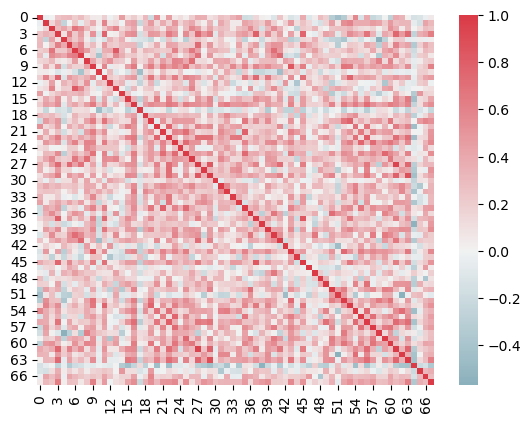

In [11]:
# Some parameters
skip = 50
data_path = '../output/parcellate/'
list_of_subjects = get_list_of_subjects('../scripts/n_files.txt')

session_data = []
session_names = []
session_corrs = []

for subject_id in list_of_subjects:
    paths = glob(data_path+'{}*'.format(subject_id))
    #print(paths)
    for path in paths:
        par = nib.load(path).get_fdata()
        par = par[::skip, :]
        session_data.append(par)
        session_names.append(os.path.split(path)[1].strip('.ptseries.nii'))
        corr = pd.DataFrame(par).corr().dropna(axis=1, how='all').dropna(axis=0, how='all').values
        session_corrs.append(corr)
    
for i in range(len(session_data)):
    fig_save_path = '../output/fMRI_corrplots/MSM_hp2000_skip50_session/{}'.format(session_names[i]+'.png')
    plot_corr(session_corrs[i], save_name=fig_save_path)

In [6]:
list_of_subjects

['100307',
 '102816',
 '105923',
 '106521',
 '108323',
 '109123',
 '111514',
 '112920',
 '113922',
 '116524',
 '116726',
 '133019',
 '140117',
 '146129',
 '149741',
 '153732',
 '154532',
 '156334',
 '158136',
 '162026',
 '162935',
 '164636',
 '166438',
 '169040',
 '172029',
 '174841',
 '175237',
 '175540',
 '177746',
 '179245',
 '181232',
 '185442',
 '187547',
 '189349',
 '191033',
 '191437',
 '191841',
 '192641',
 '195041',
 '198653',
 '204521',
 '205119',
 '212318',
 '212823',
 '214524',
 '221319',
 '223929',
 '233326',
 '248339',
 '250427',
 '255639',
 '257845',
 '283543',
 '287248',
 '293748',
 '352132',
 '352738',
 '353740',
 '358144',
 '406836',
 '433839',
 '512835',
 '555348',
 '559053',
 '568963',
 '581450',
 '599671',
 '601127',
 '660951',
 '662551',
 '665254',
 '667056',
 '679770',
 '680957',
 '706040',
 '707749',
 '715950',
 '725751',
 '735148',
 '783462',
 '814649',
 '825048',
 '872764',
 '877168',
 '891667',
 '898176',
 '912447',
 '917255',
 '990366']

In [ ]:
avg_corr = calculate_average_corr(session_corrs)
plot_corr(avg_corr, close=False)

# Test for global signal regression

In [50]:
def regress(data, nTRs, regressors, preWhitening=False):
    #print('Starting regression with {} regressors...'.format(regressors.shape[1]))
    X  = np.concatenate((np.ones([nTRs,1]), regressors), axis=1)
    N = data.shape[0]
    start_time = time()
    fit = np.linalg.lstsq(X, data.T, rcond=None)[0]
    fittedvalues = np.dot(X, fit)
    resid = data - fittedvalues.T
    data = resid
    elapsed_time = time() - start_time
    #print('Regression completed in {:02d}h{:02d}min{:02d}s'.format(int(np.floor(elapsed_time/3600)),int(np.floor((elapsed_time%3600)/60)),int(np.floor(elapsed_time%60)))) 
    return data

In [51]:
def global_signal_regression(data):
    # global signal regression
    mean_signal = np.mean(data, axis=1).reshape((data.shape[0], 1))
    out_data = regress(data.T, len(mean_signal), mean_signal).T
    return out_data

# MSM_hp2000_skip1_session

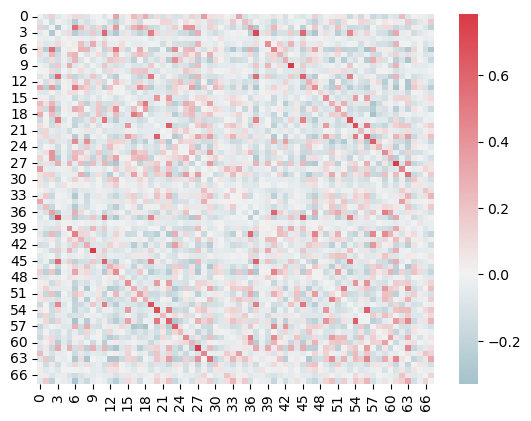

In [53]:
# Some parameters
skip = 1
data_path = '../output/parcellate/'
list_of_subjects = get_list_of_subjects('../scripts/n_files.txt')

session_data = []
session_names = []
session_corrs = []

for subject_id in list_of_subjects:
    paths = glob(data_path+'{}*'.format(subject_id))
    for path in paths:
        par = nib.load(path).get_fdata()
        par = par[::skip, :]
        
        # global signal regression
        par = global_signal_regression(par)
        
        session_data.append(par)
        session_names.append(os.path.split(path)[1].strip('.ptseries.nii'))
        corr = pd.DataFrame(par).corr().dropna(axis=1, how='all').dropna(axis=0, how='all').values
        
        np.fill_diagonal(corr, 0)
        
        session_corrs.append(corr)
    
for i in range(len(session_data)):
    fig_save_path = '../output/fMRI_corrplots/MSM_hp2000_skip1_session/{}'.format(session_names[i]+'.png')
    plot_corr(session_corrs[i], save_name=fig_save_path)
    
avg_corr = calculate_average_corr(session_corrs)
plot_corr(avg_corr, close=False)

# MSM_hp2000_skip200_session

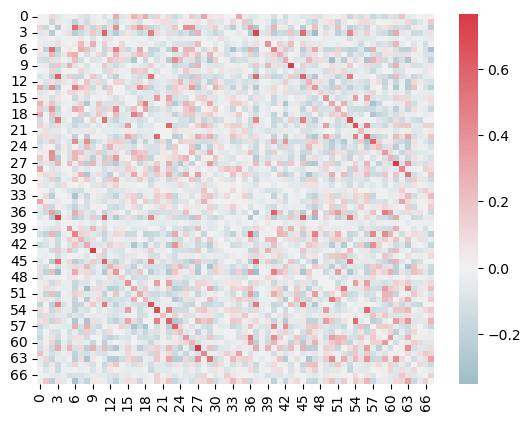

In [54]:
# Some parameters
skip = 200
data_path = '../output/parcellate/'
list_of_subjects = get_list_of_subjects('../scripts/n_files.txt')

session_data = []
session_names = []
session_corrs = []

for subject_id in list_of_subjects:
    paths = glob(data_path+'{}*'.format(subject_id))
    for path in paths:
        par = nib.load(path).get_fdata()
        par = par[::skip, :]
        
        # global signal regression
        par = global_signal_regression(par)
        
        session_data.append(par)
        session_names.append(os.path.split(path)[1].strip('.ptseries.nii'))
        corr = pd.DataFrame(par).corr().dropna(axis=1, how='all').dropna(axis=0, how='all').values
        
        np.fill_diagonal(corr, 0)
        
        session_corrs.append(corr)
    
for i in range(len(session_data)):
    fig_save_path = '../output/fMRI_corrplots/MSM_hp2000_skip200_session/{}'.format(session_names[i]+'.png')
    plot_corr(session_corrs[i], save_name=fig_save_path)
    
avg_corr = calculate_average_corr(session_corrs)
plot_corr(avg_corr, close=False)

# MSM_hp2000_skip50_session

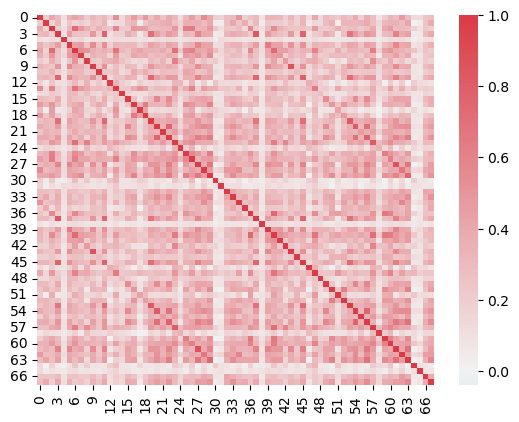

In [160]:
# Some parameters
skip = 50
run_type = 'session'
data_info = 'MSM_hp2000'
data_path = '../output/parcellate/'
list_of_subjects = get_list_of_subjects('../scripts/n_files.txt')

session_data = []
session_names = []
session_corrs = []

for subject_id in list_of_subjects:
    paths = glob(data_path+'{}*'.format(subject_id))
    for path in paths:
        par = nib.load(path).get_fdata()
        par = par[::skip, :]
        session_data.append(par)
        session_names.append(os.path.split(path)[1].strip('.ptseries.nii'))
        corr = pd.DataFrame(par).corr().dropna(axis=1, how='all').dropna(axis=0, how='all').values
        session_corrs.append(corr)
        
save_folder = '../output/fMRI_corrplots/{}_skip{}_{}'.format(data_info, str(skip), run_type)
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
    
for i in range(len(session_data)):
    fig_save_path = save_folder+'/{}'.format(session_names[i]+'.png')
    plot_corr(session_corrs[i], save_name=fig_save_path)
    
avg_corr = calculate_average_corr(session_corrs)
plot_corr(avg_corr, close=False)

# hp2000_skip50_session

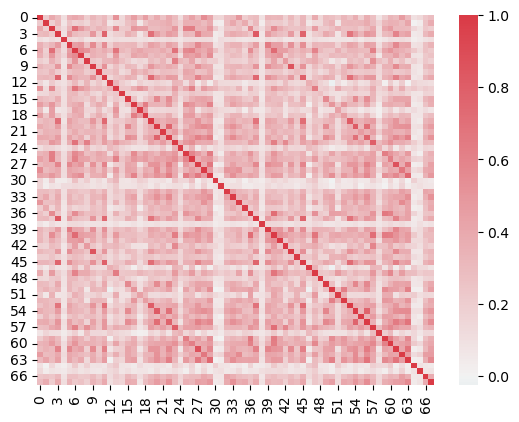

In [161]:
# Some parameters
skip = 50
run_type = 'session'
data_info = 'hp2000'
data_path = '../output/parcellate_hp2000/'
list_of_subjects = get_list_of_subjects('../scripts/n_files.txt')

session_data = []
session_names = []
session_corrs = []

for subject_id in list_of_subjects:
    paths = glob(data_path+'{}*'.format(subject_id))
    for path in paths:
        par = nib.load(path).get_fdata()
        par = par[::skip, :]
        session_data.append(par)
        session_names.append(os.path.split(path)[1].strip('.ptseries.nii'))
        corr = pd.DataFrame(par).corr().dropna(axis=1, how='all').dropna(axis=0, how='all').values
        session_corrs.append(corr)
        
save_folder = '../output/fMRI_corrplots/{}_skip{}_{}'.format(data_info, str(skip), run_type)
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
    
for i in range(len(session_data)):
    fig_save_path = save_folder+'/{}'.format(session_names[i]+'.png')
    plot_corr(session_corrs[i], save_name=fig_save_path)
    
avg_corr = calculate_average_corr(session_corrs)
plot_corr(avg_corr, close=False)

# MSM_hp2000_skip10_subject

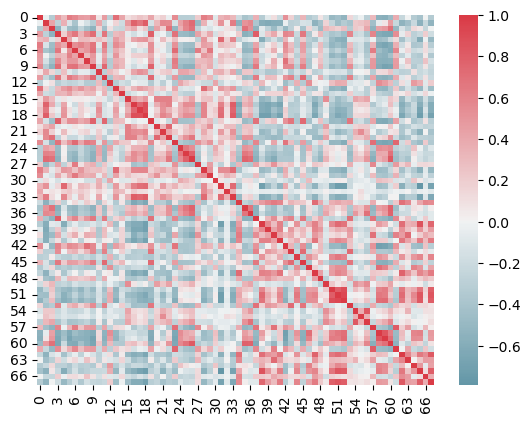

In [148]:
# Some parameters
skip = 10
data_path = '../output/parcellate/'
list_of_subjects = get_list_of_subjects('../scripts/n_files.txt')

all_subjects, all_corr = get_subject_data(list_of_subjects, data_path, skip)
# average corr
avg_corr = calculate_average_corr(all_corr)
plot_corr(avg_corr)

for i in range(len(all_corr)):
    fig_save_path = '../output/fMRI_corrplots/MSM_hp2000_skip10_subject/{}'.format(list_of_subjects[i]+'.png')
    plot_corr(all_corr[i], save_name=fig_save_path)
    
avg_corr = calculate_average_corr(all_corr)
plot_corr(avg_corr, close=False)

# MSM_hp2000_skip200_subject

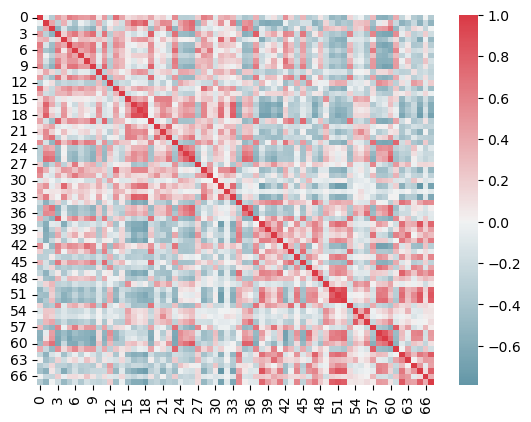

In [149]:
# Some parameters
skip = 200
run_type = 'subject'
data_info = 'MSM_hp2000'
data_path = '../output/parcellate/'
list_of_subjects = get_list_of_subjects('../scripts/n_files.txt')

all_subjects, all_corr = get_subject_data(list_of_subjects, data_path, skip)
# average corr
avg_corr = calculate_average_corr(all_corr)
plot_corr(avg_corr)

save_folder = '../output/fMRI_corrplots/{}_skip{}_{}'.format(data_info, str(skip), run_type)
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

for i in range(len(all_corr)):
    fig_save_path = save_folder + '/{}'.format(list_of_subjects[i]+'.png')
    plot_corr(all_corr[i], save_name=fig_save_path)
    
avg_corr = calculate_average_corr(all_corr)
plot_corr(avg_corr, close=False)

# MSM_hp2000_skip50_subject

In [154]:
# Some parameters
skip = 50
run_type = 'subject'
data_info = 'MSM_hp2000'
data_path = '../output/parcellate/'
list_of_subjects = get_list_of_subjects('../scripts/n_files.txt')

for subject_id in list_of_subjects:
    paths = glob('../output/parcellate/{}*'.format(subject_id))
    data = []
    for path in paths:
        par = nib.load(path)
        par_dat = par.get_fdata()
        data.append(par_dat)

    data = np.vstack(data).T
    # remove rows having all zeroes
    data = data[~np.all(data == 0, axis=1)]
    resample = data[:, ::50]
    df = pd.DataFrame(data.T)
    
    save_folder = '../output/fMRI_corrplots/{}_skip{}_{}'.format(data_info, str(skip), run_type)
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
        
    fig_save_path = save_folder + '/{}'.format(subject_id+'.png')
    
    plot_corr(df.corr(), save_name=fig_save_path)

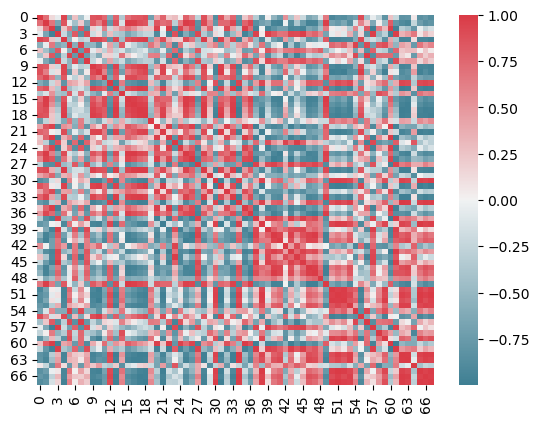

In [155]:
paths = glob('../output/parcellate/{}*'.format('100307'))
data = []
for path in paths:
    par = nib.load(path)
    par_dat = par.get_fdata()
    data.append(par_dat)

data = np.vstack(data).T
# remove rows having all zeroes
data = data[~np.all(data == 0, axis=1)]
resample = data[:, ::50]
df = pd.DataFrame(data.T)

save_folder = '../output/fMRI_corrplots/{}_skip{}_{}'.format(data_info, str(skip), run_type)
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

fig_save_path = save_folder + '/{}'.format(subject_id+'.png')

plot_corr(df.corr(), save_name=fig_save_path, close=False)

In [156]:
paths = glob('../output/parcellate/100307*')
data = []
for path in paths:
    par = nib.load(data_path)
    par_dat = par.get_fdata()
    data.append(par_dat)

data = np.vstack(data).T
# remove rows having all zeroes
data = data[~np.all(data == 0, axis=1)]
resample = data[:, ::50]
df = pd.DataFrame(data.T)
plot_corr(df.corr(), close=False)

ImageFileError: Cannot work out file type of "../output/parcellate/"

# hp200_skip100

In [125]:
# Some parameters
skip = 100
data_path = '../output/parcellate_hp2000/'
list_of_subjects = get_list_of_subjects('../scripts/n_files.txt')

all_subjects, all_corr = get_data(list_of_subjects, data_path, skip)
# average corr
avg_corr = calculate_average_corr(all_corr)
plot_corr(avg_corr)

for i in range(len(all_corr)):
    fig_save_path = '../output/fMRI_corrplots/hp2000_skip100/{}'.format(list_of_subjects[i]+'.png')
    plot_corr(all_corr[i], save_name=fig_save_path)